# #001 How does daily PM10 air pollution level differs between Kraków and Warsaw?

The first question I want to answer is close to my heart: air polution in places we live. 

Recently I was wondering how does it differ between Polish two biggest cities: Warsaw and Kraków. Kraków for sure has the opinion of the most polluted Polish city (most likely for a reason - but let's wait for the data). However recently also Warsaw entered this "high pollution" state. 

Let's see how do they compare for the past year. First let's get the data.

## Data wrangling

### Kraków
Kraków is rather easy. We can get official air pollution measurements for the past year on Wojewódzki Inspektorat Środowiska w Krakowie [website](http://monitoring.krakow.pios.gov.pl/). There are several measurement stations in Kraków. This is simple (but not simplistic!) analysis so I decided to choose the one the most in the city center instead of for example averaging all of them. So we choose measurement station located in Aleja Krasińskiego ([here](http://monitoring.krakow.pios.gov.pl/stacje/stacja/6)). We will use data from October 2016 to September 2017 (12 full months). 

We need to manually download the csv file for each month from the website. Now our task is to wrangle a little with it and join all 12 csv files into one data set and check if it was correctly loaded. 

We start with loading needed modules and setting the plots to appear inline (in Jupyter notebook itself insetad of opening separate window).

In [344]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Let's now see how the raw csv file structure looks like.

In [345]:
!cat "data/1_waw_krk_air_pollution/krakow-dane-pomiarowe_2017-10-08_23-44-16.csv"

"CZAS";"NO2 Dwutlenek azotu  [µg/m3]";"NOx Tlenki azotu  [µg/m3]";"NO Tlenek azotu  [µg/m3]";"CO Tlenek węgla  [µg/m3]";"CO Tlenek węgla 8h poz. dop.: 10000 [µg/m3]";"C6H6 Benzen  [µg/m3]";"PM10 Pył zawieszony PM10 poz. dop.: 50 [µg/m3]";"PM2.5 Pył zawieszony PM2.5  [µg/m3]"
"01.12";"41";"132";"59";"648";"764";"1,4";"28";"21"
"02.12";"42";"130";"58";"606";"804";"1,1";"26";"17"
"03.12";"42";"123";"53";"641";"856";"1,4";"41";"27"
"04.12";"54";"208";"100";"1246";"2230";"3,7";"93";"67"
"05.12";"75";"368";"192";"2145";"2727";"8,6";"181";"129"
"06.12";"55";"210";"101";"1003";"1677";"2,7";"74";"55"
"07.12";"72";"313";"158";"1278";"1768";"3,5";"99";"66"
"08.12";"60";"196";"89";"957";"1683";"2,4";"69";"46"
"09.12";"51";"161";"72";"813";"957";"1,6";"54";"30"
"10.12";"39";"115";"50";"753";"811";"1,4";"38";"24"
"11.12";"33";"92";"39";"670";"779";"1,0";"28";"19"
"12.12";"50";"157";"70";"713";"866";"0,9";"29";"16"
"13.12";"71";"310";"157";"1273";"1717";"3,1";"103";"63"
"14.12";"57";"230";"113";"1199

So we see that we will need to use ";" as a delimeter when loading the data. 

Also columns names are not to nicely formatted so it would be better if we will name them more concisely when loading the csv files. 

Another problem is that the last three rows contain agregated information (mean, min, max) and we want to keep only raw measurements. That is why we will drop last three rows from each data set.

We can also see that the data set uses ',' as a decimal separator. Missing measurements in the data are marked with `-` which should be converted to NaN format.

The last problem is the fact that source site generates record with strange date format without a year! For data series like this one it is crucial information and not having it makes it error prone. YYYY-mm-dd date format (e.g. 2016-10-01) is the most popular one and it would be useful to format it the same way Warsaw data set dates are formatted and add year information. It will be useful later in creating both cities data visualisations.

Let's now iterate through all 12 csv files, read them, merge into one DataFrame and solve mentioned problems. Then we'll check data integrity.

We start with creating merged data DataFrame.

In [346]:
import numpy as np
import os
DATA_PATH = "data/1_waw_krk_air_pollution/"

krakow_csv_list = os.listdir(DATA_PATH)
columns = ["date", "no2 [µg/m3]", "nox [µg/m3]", "no [µg/m3]", "co [µg/m3]", "co8h [µg/m3]", "c6h6 [µg/m3]", "pm10 [µg/m3]", "pm2.5 [µg/m3]"]
krakow_df_list = [pd.read_csv(DATA_PATH+krakow_csv, delimiter=";", names=columns, skiprows=1, decimal=",", na_values=["-", "-1)"]).iloc[:-3] for krakow_csv in krakow_csv_list[::-1] if "krakow" in krakow_csv]

krakow_df = pd.concat(krakow_df_list, axis=0)
krakow_df = krakow_df.reset_index(drop=True)

Then we check infered data types. 

In [347]:
krakow_df.head()

,date,no2 [µg/m3],nox [µg/m3],no [µg/m3],co [µg/m3],co8h [µg/m3],c6h6 [µg/m3],pm10 [µg/m3],pm2.5 [µg/m3]
0,01.10,74.0,235.0,105.0,963,1409.0,2.1,60,36.0
1,02.10,63.0,174.0,73.0,841,1281.0,2.1,53,34.0
2,03.10,53.0,158.0,69.0,579,781.0,1.3,25,17.0
3,04.10,47.0,158.0,73.0,504,620.0,1.3,19,11.0
4,05.10,34.0,117.0,54.0,394,562.0,1.3,13,9.0


In [348]:
krakow_df.tail()

,date,no2 [µg/m3],nox [µg/m3],no [µg/m3],co [µg/m3],co8h [µg/m3],c6h6 [µg/m3],pm10 [µg/m3],pm2.5 [µg/m3]
360,26.09,47.0,249.0,132.0,1032,1407.0,2.6,53,39.0
361,27.09,52.0,161.0,71.0,763,1294.0,1.7,45,28.0
362,28.09,59.0,201.0,92.0,839,1030.0,1.8,46,29.0
363,29.09,69.0,317.0,161.0,1194,NaN,NaN,73,51.0
364,30.09,57.0,208.0,98.0,1188,1669.0,NaN,71,54.0


In [349]:
krakow_df.dtypes

date              object
no2 [µg/m3]      float64
nox [µg/m3]      float64
no [µg/m3]       float64
co [µg/m3]         int64
co8h [µg/m3]     float64
c6h6 [µg/m3]     float64
pm10 [µg/m3]       int64
pm2.5 [µg/m3]    float64
dtype: object

The date column should be in datetime type with format we described above. 

In [350]:
from datetime import datetime

def convert_dates_and_add_year(date):
    reversed_split_date = date.split(".")[::-1]
    if int(reversed_split_date[0]) > 9:
        date_str = "2016-"+"-".join(reversed_split_date)
    else:
        date_str = "2017-"+"-".join(reversed_split_date)
    return datetime.strptime(date_str, "%Y-%m-%d")

krakow_df["date"] = krakow_df["date"].apply(convert_dates_and_add_year)

In [351]:
krakow_df.dtypes

date             datetime64[ns]
no2 [µg/m3]             float64
nox [µg/m3]             float64
no [µg/m3]              float64
co [µg/m3]                int64
co8h [µg/m3]            float64
c6h6 [µg/m3]            float64
pm10 [µg/m3]              int64
pm2.5 [µg/m3]           float64
dtype: object

In [352]:
krakow_df.head(10)

,date,no2 [µg/m3],nox [µg/m3],no [µg/m3],co [µg/m3],co8h [µg/m3],c6h6 [µg/m3],pm10 [µg/m3],pm2.5 [µg/m3]
0,2016-10-01,74.0,235.0,105.0,963,1409.0,2.1,60,36.0
1,2016-10-02,63.0,174.0,73.0,841,1281.0,2.1,53,34.0
2,2016-10-03,53.0,158.0,69.0,579,781.0,1.3,25,17.0
3,2016-10-04,47.0,158.0,73.0,504,620.0,1.3,19,11.0
4,2016-10-05,34.0,117.0,54.0,394,562.0,1.3,13,9.0
5,2016-10-06,45.0,209.0,108.0,611,877.0,2.1,30,19.0
6,2016-10-07,54.0,236.0,119.0,893,1067.0,3.1,64,43.0
7,2016-10-08,43.0,160.0,77.0,836,1051.0,2.9,77,55.0
8,2016-10-09,40.0,155.0,75.0,818,1108.0,3.1,68,49.0
9,2016-10-10,54.0,241.0,123.0,901,1120.0,2.3,57,40.0


In [353]:
krakow_df.tail(10)

,date,no2 [µg/m3],nox [µg/m3],no [µg/m3],co [µg/m3],co8h [µg/m3],c6h6 [µg/m3],pm10 [µg/m3],pm2.5 [µg/m3]
355,2017-09-21,60.0,177.0,76.0,753,1058.0,1.4,21,19.0
356,2017-09-22,56.0,185.0,84.0,759,897.0,1.4,30,25.0
357,2017-09-23,39.0,132.0,61.0,789,949.0,1.8,27,25.0
358,2017-09-24,42.0,164.0,80.0,867,976.0,1.8,26,22.0
359,2017-09-25,50.0,204.0,101.0,860,1014.0,1.6,33,25.0
360,2017-09-26,47.0,249.0,132.0,1032,1407.0,2.6,53,39.0
361,2017-09-27,52.0,161.0,71.0,763,1294.0,1.7,45,28.0
362,2017-09-28,59.0,201.0,92.0,839,1030.0,1.8,46,29.0
363,2017-09-29,69.0,317.0,161.0,1194,NaN,NaN,73,51.0
364,2017-09-30,57.0,208.0,98.0,1188,1669.0,NaN,71,54.0


In [354]:
krakow_df.count()

date             365
no2 [µg/m3]      363
nox [µg/m3]      363
no [µg/m3]       363
co [µg/m3]       365
co8h [µg/m3]     364
c6h6 [µg/m3]     342
pm10 [µg/m3]     365
pm2.5 [µg/m3]    305
dtype: int64

The data looks corrects with records starting 2016-10-01 and ending 2017-09-30. This means that we should have 365 records which is proved for our DataFrame records number.

### Warsaw

Getting Warsaw data is even easier! We get the official air pollution measurements for the past year on Główny  Inspektorat Środowiska [website](http://powietrze.gios.gov.pl/). There are also several measurement stations in Warsaw. Again we decided to choose the one the most in the city center - we choose measurement station located in ul. Marszałkowska 68. In this case we can generate manually data set for given range of dates, measured pollutant and selected measurement station ([here](http://powietrze.gios.gov.pl/pjp/current/station_details/archive/544)).

Let's see how downloaded data set looks like.

In [355]:
!cat data/1_waw_krk_air_pollution/warszawa-gios-pjp-data.csv

Zanieczyszczenie;Warszawa-Marszałkowska - pył zawieszony PM10
Jednostka;ug/m3
2016-10-01;36.0
2016-10-02;34.7
2016-10-03;32.1
2016-10-04;25.6
2016-10-05;10.6
2016-10-06;23.2
2016-10-07;28.1
2016-10-08;20.0
2016-10-09;23.9
2016-10-10;22.7
2016-10-11;14.2
2016-10-12;17.1
2016-10-13;27.5
2016-10-14;36.0
2016-10-15;32.4
2016-10-16;28.2
2016-10-17;30.9
2016-10-18;30.5
2016-10-19;
2016-10-20;
2016-10-21;32.4
2016-10-22;29.1
2016-10-23;39.2
2016-10-24;38.7
2016-10-25;35.5
2016-10-26;28.7
2016-10-27;39.4
2016-10-28;39.9
2016-10-29;14.2
2016-10-30;12.8
2016-10-31;14.5
2016-11-01;19.5
2016-11-02;15.6
2016-11-03;15.0
2016-11-04;30.2
2016-11-05;51.2
2016-11-06;34.5
2016-11-07;34.5
2016-11-08;46.8
2016-11-09;42.2
2016-11-10;48.3
2016-11-11;39.7
2016-11-12;51.5
2016-11-13;42.0
2016-11-14;38.2
2016-11-15;49.9
2016-11-16;31.9
2016-11-17;31.9
2016-11-18;42.3
2016-11-19;45.4
2016-11-20;26.9
2016-11-21;37.9
2016-11-22;37.6
2016-11-23;54.8
2016-11-24;71.6
2016-11-25;57.2
2016-11-26;49.1
2016-11-27;27.1
20

We see here that ";" is the delimeter and that data set has more robust timestamp format conaining a year. 

And among all that data contains only information contains only PM10 measurements so no data wrangling is needed besides naming the columns.

In [356]:
warszawa_df = pd.read_csv(DATA_PATH+"warszawa-gios-pjp-data.csv", delimiter=";", names=["date", "pm10 [µg/m3]"], skiprows=2)

In [357]:
warszawa_df.head(10)

,date,pm10 [µg/m3]
0,2016-10-01,36.0
1,2016-10-02,34.7
2,2016-10-03,32.1
3,2016-10-04,25.6
4,2016-10-05,10.6
5,2016-10-06,23.2
6,2016-10-07,28.1
7,2016-10-08,20.0
8,2016-10-09,23.9
9,2016-10-10,22.7


In [358]:
warszawa_df.tail(10)

,date,pm10 [µg/m3]
355,2017-09-21,23.3
356,2017-09-22,20.2
357,2017-09-23,35.0
358,2017-09-24,35.3
359,2017-09-25,29.7
360,2017-09-26,45.8
361,2017-09-27,36.0
362,2017-09-28,27.2
363,2017-09-29,43.6
364,2017-09-30,41.6


In [359]:
warszawa_df.count()

date            365
pm10 [µg/m3]    363
dtype: int64

Again data looks complete in our specified dates range. Looks like we miss two measurements, but we will see it later during exploration.

## Exploration and conclusions

We have the data so let's answer our question: How does daily PM10 air pollution level differs between Kraków and Warsaw?

First let's try to answer by generating proper plots.

In [360]:
import matplotlib.pyplot as plt
%matplotlib inline

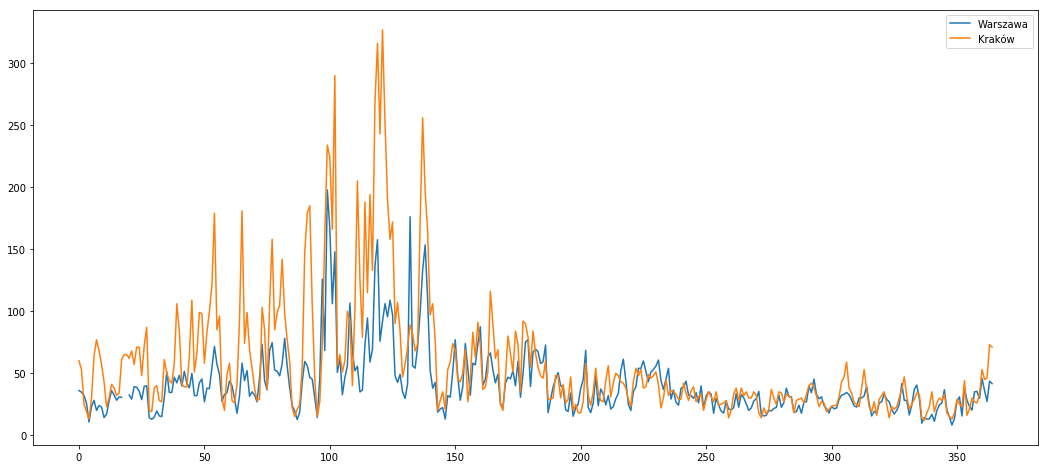

In [366]:
fig, axes = plt.subplots(figsize=(18, 8))
# axes.plot(warszawa_df["pm10 [µg/m3]"], label="Warszawa")
axes.plot(krakow_df["pm10 [µg/m3]"], label="Kraków")
axes.legend(loc=0)

The plot is not clear enough. We can see some differences but there are several factors that makes it difficult analyse.

First of all we need to add dates to the x axis so we could clearly read periods.

Second we need to indicate the norm level.

Days above 100 level.

Third we can create metric measuring air polution level. This could be for example how many days in a year period PM10 pollution is above the norm in given city.

Let's plot quarterly!